In [30]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
import tsfel

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, balanced_accuracy_score, euclidean_distances

from scipy.spatial.distance import cosine

from metrics import acc

from data import get_training_and_validation_data
from autoencoder import Autoencoder, VariationalAutoencoder, CategoricalAutoencoder, ConvolutionalCategoricalAutoencoder

model_id = 'F3PNBBSMMR'
model_config = json.load(open(Path('models') / model_id / 'config.json', 'r'))
dataset_id = model_config['dataset_id']
model_type = model_config['model']

X_train, X_feat_train, y_train, X_val, X_feat_val, y_val = get_training_and_validation_data(
    Path('processed_data'), dataset_id, classes=model_config.get('classes', None), balanced=False)
# X_mean, X_std = X_train.mean(), X_train.std()
# X_train -= X_mean
# X_train /= X_std
# X_val -= X_mean
# X_val /= X_std

X_min, X_max = X_train.min(), X_train.max()
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
X_val_tensor = torch.from_numpy(X_val).to(torch.float32)

if model_config['model'] == 'vae':
    model = VariationalAutoencoder
elif model_config['model'] == 'cae':
    model = CategoricalAutoencoder
elif model_config['model'] == 'convcae':
    model = ConvolutionalCategoricalAutoencoder
else:
    model = Autoencoder

autoencoder = model(input_dim=X_train.shape[1], **model_config)
autoencoder.load_state_dict(torch.load(Path('models') / model_id / 'ae.pth'))
autoencoder.eval()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_train_mu, X_train_log = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(X_train_mu, X_train_log)
else:
    X_train_enc = autoencoder.encode(X_train_tensor)
X_train_rec = autoencoder.decode(X_train_enc)
print('MSE LOSS:', torch.nn.functional.mse_loss(X_train_tensor, X_train_rec).item())
X_train_rec = X_train_rec.detach().numpy()
X_train_enc = X_train_enc.detach().numpy()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_val_mu, X_val_log = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(X_val_mu, X_val_log)
else:
    X_val_enc = autoencoder.encode(X_val_tensor)
X_val_rec = autoencoder.decode(X_val_enc).detach().numpy()
X_val_enc = X_val_enc.detach().numpy()

MSE LOSS: 0.001447583083063364


# Visualization

In [ ]:
data = pd.DataFrame(X_train_enc, columns=[f'Dim_{i+1}' for i in range(X_train_enc.shape[1])])
data['Class'] = y_train

# Plot violin plots for each dimension
for column in data.columns[:-1]:  # Exclude the 'Class' column for the plots
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Class', y=column, data=data, hue='Class', palette='muted', legend=False)
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.show()

0.000396143211080292


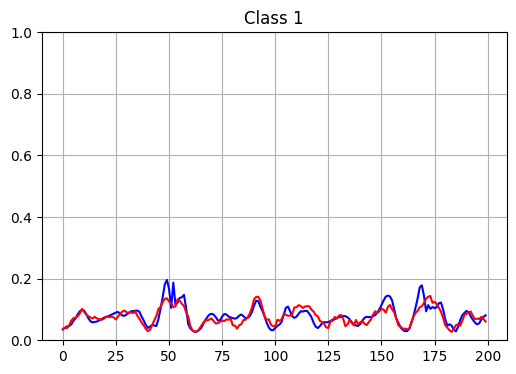

0.0008671820468408659


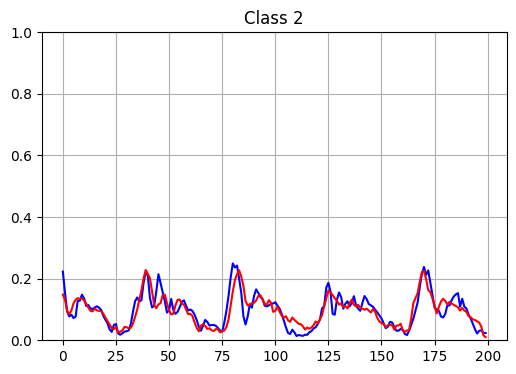

0.0025858505876222545


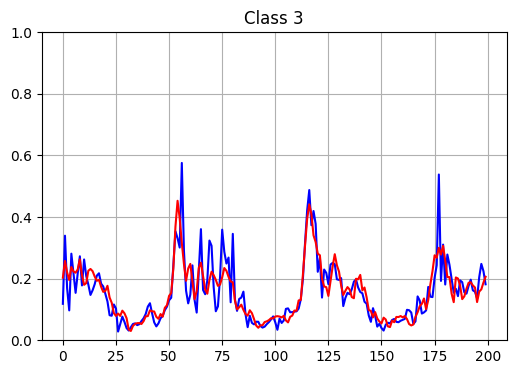

In [4]:
samples = {}
for class_label in np.unique(y_train):
    indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(indices)
    samples[class_label] = X_train[random_index], X_train_rec[random_index]

for class_label, (sample, rec_sample) in samples.items():
    plt.figure(figsize=(6, 4))
    plt.plot(sample, color='b')
    plt.plot(rec_sample, color='r')
    print(((sample - rec_sample)**2).mean())
    plt.title(f"Class {class_label}")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Evaluation

In [5]:
mean, std = X_train_enc.mean(), X_train_enc.std()
X_train_enc -= mean
X_train_enc /= std
X_val_enc -= mean
X_val_enc /= std

kmeans = KMeans(n_clusters=len(np.unique(y_train)))
kmeans.fit(X_train_enc)
y_pred = kmeans.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           1       0.77      1.00      0.87     15035
           2       0.85      0.54      0.66      9923
           3       0.92      0.38      0.53      1555

    accuracy                           0.79     26513
   macro avg       0.85      0.64      0.69     26513
weighted avg       0.81      0.79      0.77     26513



In [6]:
kmeans = KMeans(n_clusters=len(np.unique(y_train)))
kmeans.fit(X_train)
y_pred = kmeans.predict(X_val)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           1       0.61      1.00      0.76     15035
           2       0.21      0.02      0.03      9923
           3       0.86      0.46      0.60      1555

    accuracy                           0.60     26513
   macro avg       0.56      0.49      0.46     26513
weighted avg       0.47      0.60      0.48     26513



# Distance based clustering

In [1]:
import numpy as np
from distance_matrix import dtw_njit, dtw_c

_ = dtw_njit(np.random.randn(100), np.random.randn(100))
_ = dtw_c(np.random.randn(100), np.random.randn(100))

## Equine data

In [56]:
from data import load_dataset
from distance_matrix import parallel_distance_matrix

N = 2000

X, y = load_dataset(Path('processed_data'), dataset_id='RTAGXFQJ4T') # FFT
# X, y = load_dataset(Path('processed_data'), dataset_id='K6WZL7BWHQ') # Raw
X, y = X[0][:, :, 0], y[0]
X = X[y != 0]
y = y[y != 0]
X_min, X_max = X.min(), X.max()
X -= X_min
X /= (X_max - X_min)
indices = np.random.choice(len(X), N)
X, y = X[indices], y[indices]
print(X.shape, np.unique(y, return_counts=True))

distances = parallel_distance_matrix(X)
sums = distances.sum(axis=1)
distances = distances / sums[:, np.newaxis]


(2000, 100) (array([1, 2, 3]), array([ 810, 1029,  161]))


In [62]:
km = KMeans(n_clusters=3, n_init='auto')
y_pred = km.fit_predict(X)
_, label_mapping = acc(y, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
balanced_accuracy_score(y, y_pred)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.89      1.00      0.94       810
           2       0.98      0.90      0.94      1029
           3       0.98      0.91      0.95       161

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.95      0.94      0.94      2000



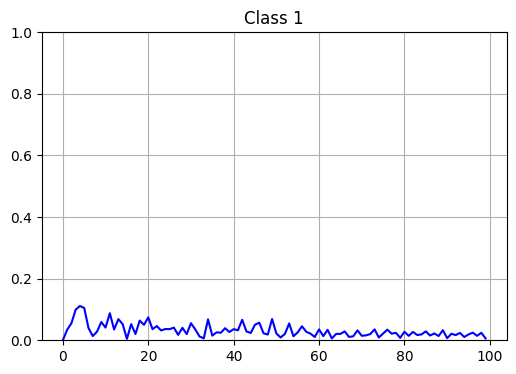

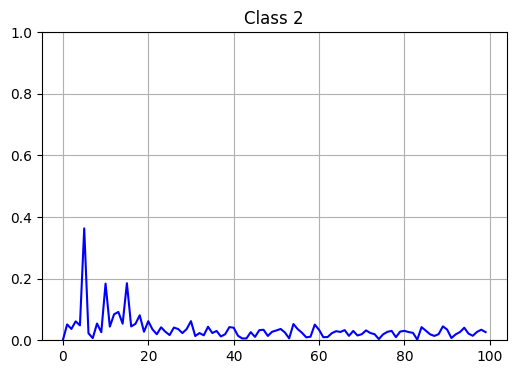

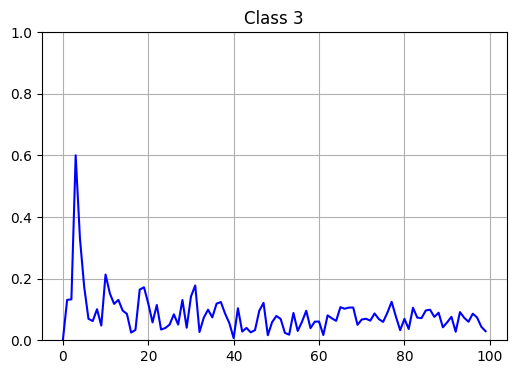

In [57]:
samples = {}
for class_label in np.unique(y):
    indices = np.where(y == class_label)[0]
    random_index = np.random.choice(indices)
    samples[class_label] = X[random_index]

for class_label, sample in samples.items():
    plt.figure(figsize=(6, 4))
    plt.plot(sample, color='b')
    plt.title(f"Class {class_label}")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

In [58]:
from sklearn.cluster import AgglomerativeClustering,  DBSCAN
from collections import defaultdict

def cluster_time_series(distances, n_clusters=None):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = clustering_model.fit_predict(distances)
    return labels

clusters = cluster_time_series(distances, n_clusters=10)
cluster_label_mapping = defaultdict(list)
for label, cluster in zip(y, clusters):
    cluster_label_mapping[cluster].append(label)

for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l.tolist(), c.tolist()}")
print()
for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l[np.argmax(c)]} ({(np.max(c) / np.sum(c)):.2%} - {c.sum()})")

Cluster 0 -> ([2, 3], [95, 21])
Cluster 1 -> ([2], [492])
Cluster 2 -> ([1, 2, 3], [2, 126, 4])
Cluster 3 -> ([2], [63])
Cluster 4 -> ([2, 3], [138, 1])
Cluster 5 -> ([3], [2])
Cluster 6 -> ([1, 2], [808, 73])
Cluster 7 -> ([2, 3], [17, 18])
Cluster 8 -> ([2, 3], [5, 115])
Cluster 9 -> ([2], [20])

Cluster 0 -> 2 (81.90% - 116)
Cluster 1 -> 2 (100.00% - 492)
Cluster 2 -> 2 (95.45% - 132)
Cluster 3 -> 2 (100.00% - 63)
Cluster 4 -> 2 (99.28% - 139)
Cluster 5 -> 3 (100.00% - 2)
Cluster 6 -> 1 (91.71% - 881)
Cluster 7 -> 3 (51.43% - 35)
Cluster 8 -> 3 (95.83% - 120)
Cluster 9 -> 2 (100.00% - 20)


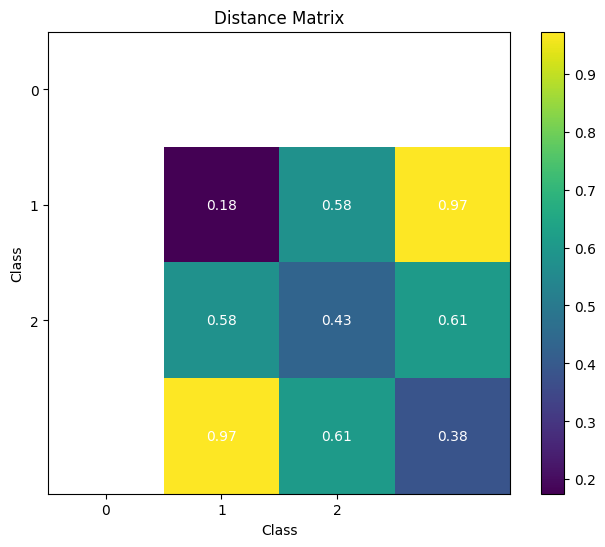

In [60]:
distance_dict = defaultdict(list)
for i in range(N):
    for j in range(i + 1, N):
        l_i, l_j = y[i], y[j]
        distance_dict[(min(l_i, l_j), max(l_i, l_j))].append(distances[i, j] * 1000)

mean_dict = {k: np.mean(v) for k, v in distance_dict.items()}
max_index = max(max(k) for k in mean_dict.keys()) + 1
matrix = np.full((max_index, max_index), np.nan)

# Populate the distance matrix
for (i, j), distance in mean_dict.items():
    matrix[i, j] = distance
    matrix[j, i] = distance
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='none')

# Add text annotations for each cell
for i in range(max_index):
    for j in range(max_index):
        distance = matrix[i, j]
        if not np.isnan(distance):
            plt.text(j, i, f'{distance:.2f}', ha='center', va='center', color='white' if distance < 2 else 'black')

plt.title('Distance Matrix')
plt.xlabel('Class')
plt.ylabel('Class')
plt.xticks(range(len(np.unique(y))))
plt.yticks(range(len(np.unique(y))))
plt.colorbar()
plt.show()

# {k: v for k, v in mean_dict.items() if k[0] == k[1]}, {k: v for k, v in mean_dict.items() if k[0] != k[1]}

In [78]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter


def find_k_nearest_neighbors(X, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    return distances, indices


def generate_synthetic_samples(X, k_neighbors, true_labels, n_samples):
    n_features = X.shape[1]
    synthetic_samples = np.zeros((n_samples, n_features))
    labels_of_generated_samples = np.zeros(n_samples, dtype=np.int64)
    for i in range(n_samples):
        sample_idx = np.random.randint(0, X.shape[0])
        neighbor_idx = np.random.choice(k_neighbors[sample_idx])
        diff = X[neighbor_idx] - X[sample_idx]
        synthetic_samples[i] = X[sample_idx] + np.random.rand() * diff
        labels_of_generated_samples[i] = true_labels[sample_idx]
    return synthetic_samples, labels_of_generated_samples


def custom_smote_balancing(time_series_data, cluster_labels, true_labels, k=5):
    unique_clusters = np.unique(cluster_labels)
    synthetic_data = []
    synthetic_labels = []
    
    # Determine cluster distribution
    class_counter = Counter(cluster_labels)
    max_samples = max(class_counter.values())
    
    for cluster in unique_clusters:
        # Get data points and their true labels in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_data = time_series_data[cluster_indices]
        cluster_true_labels = np.array(true_labels)[cluster_indices]
        
        # Find k-nearest neighbors for data in the cluster
        _, k_neighbors = find_k_nearest_neighbors(cluster_data, k)
        
        # Determine the number of samples to generate
        n_samples = max_samples - class_counter[cluster]
        
        if n_samples <= 0:
            continue
        
        # Generate synthetic samples
        synthetic_samples, labels_of_generated_samples = generate_synthetic_samples(cluster_data, k_neighbors, cluster_true_labels, n_samples)
        
        # Append synthetic samples and their corresponding true labels
        synthetic_data.append(synthetic_samples)
        synthetic_labels.extend(labels_of_generated_samples)
    
    # Reshape synthetic data to the original time-series shape
    synthetic_data = np.vstack(synthetic_data).reshape(-1, time_series_data.shape[1], time_series_data.shape[2])
    balanced_data = np.concatenate((time_series_data, synthetic_data))
    balanced_labels = np.concatenate((true_labels, synthetic_labels))

    return balanced_data, balanced_labels

In [79]:
clusters = cluster_time_series(distances, n_clusters=10)
custom_smote_balancing(X, clusters, y)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 5

## MNIST

In [5]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.cluster import AgglomerativeClustering

from metrics import acc
from distance_matrix import parallel_distance_matrix

def get_kmeans_result(X, y):
    km = KMeans(n_clusters=len(np.unique(y)), n_init='auto')
    y_pred = km.fit_predict(X)
    _, label_mapping = acc(y, y_pred, return_mapping=True)
    y_pred = np.vectorize(label_mapping.get)(y_pred)
    return accuracy_score(y, y_pred), balanced_accuracy_score(y, y_pred)

In [6]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
accuracy, bal_acc = get_kmeans_result(X, y)
print(f"{accuracy:.3%}, {bal_acc:.3%}")

78.687%, 78.694%


In [14]:
# Asymmetric undersampling

undersampling_pct = .01

for undersampled_digit in range(10):
    digit_indices = np.where(y == undersampled_digit)[0]
    selected_indices = np.random.choice(digit_indices, int(len(digit_indices) * undersampling_pct))
    mask = y != undersampled_digit
    mask[selected_indices] = True
    X_sel, y_sel = X[mask], y[mask]
    accuracy, bal_acc = get_kmeans_result(X_sel, y_sel)
    print(f"Digit {undersampled_digit}: {accuracy:.3%}; {bal_acc:.3%}")

Digit 0: 72.778%; 65.521%
Digit 1: 74.443%; 66.949%
Digit 2: 64.035%; 57.442%
Digit 3: 83.901%; 75.596%
Digit 4: 70.501%; 63.489%
Digit 5: 72.710%; 65.502%
Digit 6: 64.255%; 57.911%
Digit 7: 74.305%; 66.903%
Digit 8: 85.837%; 77.309%
Digit 9: 78.430%; 70.637%


In [18]:
# Symmetric undersampling

undersampling_pct = .05

mask = np.random.choice(len(y), int(len(y) * undersampling_pct))
X_sel, y_sel = X[mask], y[mask]
km = KMeans(n_clusters=len(np.unique(y)), n_init='auto')
km.fit(X_sel)
y_pred = km.predict(X)
_, label_mapping = acc(y, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(f"{accuracy_score(y, y_pred):.3%}; {balanced_accuracy_score(y, y_pred):.3%}")
np.unique(y_sel, return_counts=True)

75.570%; 75.480%


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10,  7,  5, 12,  8, 12,  8,  7,  9, 11]))

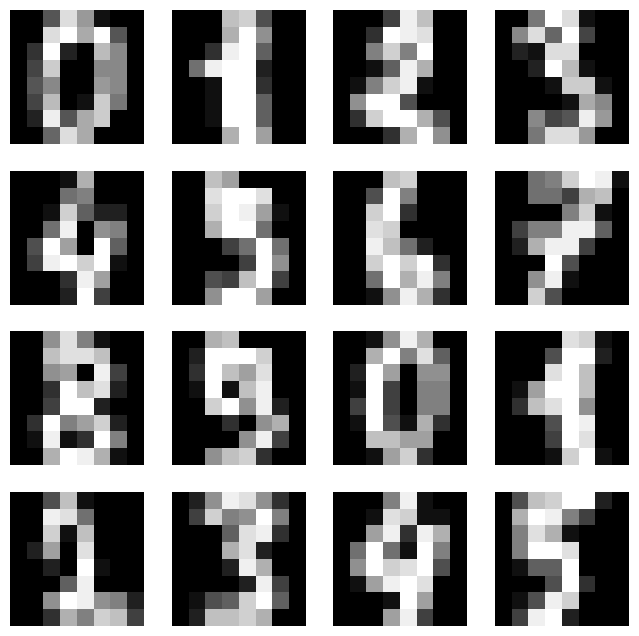

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # Assuming each entry in grid_data is a flat array of 64 values (8x8)
    img = X[:16][i].reshape((8, 8))  # reshape 64 values back to an 8x8 grid
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.axis('off')

plt.show()

In [18]:
X, X_train

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

# Feature based clustering

In [57]:
from scipy.stats import kendalltau

_, X_feat_train, y_train, _, X_feat_val, y_val = get_training_and_validation_data(
    Path('processed_data'), 'K6WZL7BWHQ', classes=[1, 2, 3], balanced=False)

tau_vals = sorted([(feat, (result.pvalue, -abs(result.statistic))) for feat, result in [(feat, kendalltau(X_feat_train[:, feat], y_train)) for feat in range(X_feat_train.shape[-1])]], key=lambda r: r[1])
sorted_features = [feat for feat, _ in tau_vals]
X_feat_train = X_feat_train[:, sorted_features]
X_feat_val = X_feat_val[:, sorted_features]
feat_mean, feat_std = X_feat_train.mean(), X_feat_train.std()
X_feat_train -= feat_mean
X_feat_train /= feat_std
X_feat_val -= feat_mean
X_feat_val /= feat_std


In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_feat, y_train = smote.fit_resample(X_feat_train, y_train)

In [58]:
n_features = 234
km = KMeans(n_clusters=3)
km.fit(X_feat_train[:, :n_features])
y_pred = km.predict(X_feat_val[:, :n_features])
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           1       0.94      1.00      0.97     15035
           2       0.94      0.89      0.91      9923
           3       0.81      0.69      0.75      1555

    accuracy                           0.94     26513
   macro avg       0.90      0.86      0.88     26513
weighted avg       0.94      0.94      0.94     26513



In [60]:
n_features = 234
gmm = GaussianMixture(n_components=3)
gmm.fit(X_feat_train[:, :n_features])
y_pred = gmm.predict(X_feat_val[:, :n_features])
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98     15035
           2       0.95      0.95      0.95      9923
           3       0.84      0.94      0.89      1555

    accuracy                           0.96     26513
   macro avg       0.93      0.95      0.94     26513
weighted avg       0.96      0.96      0.96     26513



In [55]:
X_feat_train.shape

(51025, 234)